In [456]:
# importing required libraries
import pickle
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model, save_model
from tensorflow.keras.layers import Embedding, Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM
from tensorflow.keras.optimizers import RMSprop
import math
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt

# Loading the dataset
 https://research.fb.com/downloads/babi/  
 The BaBi dataset serves as the cornerstone of our project.  


 It contains a diverse set of tasks, each designed to evaluate specific aspects of a model’s reasoning abilities. The dataset
 encompasses a range of story types, making it a comprehensive resource for training and
 evaluating our chatbot.


In [457]:
with open("train_qa.txt", "rb") as fp:   # Unpickling, read-binary
    train_data =  pickle.load(fp)
with open("test_qa.txt", "rb") as fp:   # Unpickling, read-binary
    test_data =  pickle.load(fp)

In [458]:
# Display types and lengths of the loaded data
print(type(train_data), len(train_data))
print(type(test_data), len(test_data))

<class 'list'> 10000
<class 'list'> 1000


# Understanding the Data Schema

In [459]:
# Display information about the first data point
print(len(train_data[0]), type(train_data[0]))

3 <class 'tuple'>


In [460]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [461]:
# Display the story, question, and answer for the first 5 data points
text = ''

print('Story:')
for i in range(5):
     print(f"Train datapoint no.: {i}")
     for sent in train_data[i]:
        if sent not in ['yes', 'no']:
            for word in sent:
                if word != '.':
                    if word != '?':
                        text += word + ' '
                    else:
                        print()
                        print('Question:', text[:-1] + word)
                        print()
                        text = ''
                else:
                    print(text[:-1] + word)
                    text = ''
        else:
            print('Answer:', sent, '\n')

Story:
Train datapoint no.: 0
Mary moved to the bathroom.
Sandra journeyed to the bedroom.

Question: Is Sandra in the hallway?

Answer: no 

Train datapoint no.: 1
Mary moved to the bathroom.
Sandra journeyed to the bedroom.
Mary went back to the bedroom.
Daniel went back to the hallway.

Question: Is Daniel in the bathroom?

Answer: no 

Train datapoint no.: 2
Mary moved to the bathroom.
Sandra journeyed to the bedroom.
Mary went back to the bedroom.
Daniel went back to the hallway.
Sandra went to the kitchen.
Daniel went back to the bathroom.

Question: Is Daniel in the office?

Answer: no 

Train datapoint no.: 3
Mary moved to the bathroom.
Sandra journeyed to the bedroom.
Mary went back to the bedroom.
Daniel went back to the hallway.
Sandra went to the kitchen.
Daniel went back to the bathroom.
Daniel picked up the football there.
Daniel went to the bedroom.

Question: Is Daniel in the bedroom?

Answer: yes 

Train datapoint no.: 4
Mary moved to the bathroom.
Sandra journeyed to 

In [462]:
# Combine train and test data for vocabulary creation
all_data = train_data + test_data

In [463]:
len(all_data)

11000

# Setting up Vocabulary of All Words

In [464]:
# Create a set that holds the vocab words
vocab = set()

In [465]:
# Update vocabulary with words from stories and questions
for story, question, answer in all_data:
    vocab.update(set(story))
    vocab.update(set(question))

In [466]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went'}

In [467]:
# Display the size of the vocabulary
print(len(vocab))

35


In [468]:
# Add 'yes' and 'no' to the vocabulary
vocab.add('yes')
vocab.add('no')

In [469]:
len(vocab)

37

In [470]:
# Increase vocabulary size by 1 for padding
vocab_size = len(vocab) + 1

In [471]:
# Display maximum story and question lengths
max_story_len = max(len(data[0]) for data in all_data)
max_question_len = max(len(data[1]) for data in all_data)

In [472]:
# Display vocabulary size, max story length, and max question length
print(f'vocab_size: {vocab_size}, max_story_len: {max_story_len}, max_question_len: {max_question_len}')

vocab_size: 38, max_story_len: 156, max_question_len: 6


# Data Vectorization

In [473]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [474]:
# Initialize a Tokenizer and fit on the vocabulary
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [475]:
# Display word index dictionary
tokenizer.word_index

{'is': 1,
 'travelled': 2,
 'milk': 3,
 'in': 4,
 'john': 5,
 'went': 6,
 'moved': 7,
 'football': 8,
 'up': 9,
 'dropped': 10,
 '?': 11,
 'daniel': 12,
 'left': 13,
 '.': 14,
 'apple': 15,
 'to': 16,
 'put': 17,
 'back': 18,
 'office': 19,
 'grabbed': 20,
 'discarded': 21,
 'hallway': 22,
 'got': 23,
 'down': 24,
 'took': 25,
 'garden': 26,
 'picked': 27,
 'mary': 28,
 'journeyed': 29,
 'no': 30,
 'the': 31,
 'yes': 32,
 'sandra': 33,
 'there': 34,
 'bedroom': 35,
 'bathroom': 36,
 'kitchen': 37}

In [476]:
# Initialize lists for story text, question text, and answers
train_story_text, train_question_text, train_answers = [], [], []

In [477]:
# Separate stories, questions, and answers from training data
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [478]:
# Convert story text to sequences using the Tokenizer
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [479]:
# Display lengths of original text and corresponding sequences
print(len(train_story_text), len(train_story_seq))

10000 10000


## Function to vectorize data into padded sequences

In [480]:

def vectorize_data(input_data, word_index=tokenizer.word_index, max_input_len=max_story_len, max_query_len=max_question_len):
    '''
    INPUT:

    input_data: List of tuples containing input Stories, Queries, and Answers
    word_index: Word index dictionary from tokenizer
    max_input_len: Length of the longest input sequence (used for pad_sequences function)
    max_query_len: Length of the longest query (used for pad_sequences function)

    OUTPUT:

    Vectorizes the input stories, queries, and one-hot encodes the answers into padded sequences.
    Each word in the story and query is converted to its corresponding word index value.
    The sequences are then padded to ensure uniform length.

    Returns a tuple (X_input, X_query, Y_answer) containing the padded sequences for input stories, queries, and answers.

    '''

    # X_input = STORIES, X_query = QUERIES, Y_answer = ANSWERS
    X_input, X_query, Y_answer = [], [], []

    for story, query, answer in input_data:
        # Convert words in the story to their word index values
        x_input = [word_index[word.lower()] for word in story]
        # Convert words in the query to their word index values
        x_query = [word_index[word.lower()] for word in query]

        # One-hot encode the correct answer
        y_answer = np.zeros(vocab_size)
        y_answer[word_index[answer]] = 1

        # Append each set of input story, query, and answer to their respective lists
        X_input.append(x_input)
        X_query.append(x_query)
        Y_answer.append(y_answer)

    # Pad the sequences based on their max length to ensure uniform length for training
    # RETURN TUPLE FOR UNPACKING
    return pad_sequences(X_input, maxlen=max_input_len), pad_sequences(X_query, maxlen=max_query_len), np.array(Y_answer)



In [481]:
# Vectorize training and testing data
inputs_train, queries_train, answers_train = vectorize_data(train_data)
inputs_test, queries_test, answers_test = vectorize_data(test_data)

In [482]:
inputs_test

array([[ 0,  0,  0, ..., 31, 35, 14],
       [ 0,  0,  0, ..., 31, 26, 14],
       [ 0,  0,  0, ..., 31, 26, 14],
       ...,
       [ 0,  0,  0, ..., 31, 15, 14],
       [ 0,  0,  0, ..., 31, 26, 14],
       [ 0,  0,  0, ..., 15, 34, 14]], dtype=int32)

In [483]:
queries_test

array([[ 1,  5,  4, 31, 37, 11],
       [ 1,  5,  4, 31, 37, 11],
       [ 1,  5,  4, 31, 26, 11],
       ...,
       [ 1, 28,  4, 31, 35, 11],
       [ 1, 33,  4, 31, 26, 11],
       [ 1, 28,  4, 31, 26, 11]], dtype=int32)

In [484]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [485]:
# Found almost equal proportion of Yes / No answers (no imbalance in dataset)
print(sum(answers_test))

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 503.   0. 497.   0.   0.   0.   0.   0.]


In [486]:
tokenizer.word_index['yes']

32

In [487]:
tokenizer.word_index['no']

30

# Model creation

# Placeholders for Input Sequences
There will be 2 inputs story and question, respectively.

In [488]:
# Define input layers for story and question
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

## Building the networks

# Encoders

### Input encoder m

In [489]:
embedding_dim = 64

In [490]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim= embedding_dim))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

###Input encoder c

In [491]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

### Question Encoder

In [492]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

#### Encoding the sequences

In [493]:
# encode input sequence and questions (which are indices) to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [494]:
# shape: (samples, story_maxlen, query_maxlen)
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [495]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [496]:
# concatenate the match matrix with the question vector sequence
# (samples, query_maxlen, story_maxlen + embedding_dim)
answer = concatenate([response, question_encoded])

In [497]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_5')>

In [498]:
answer= LSTM(32)(answer)

In [499]:
# Regularization with Dropout
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [500]:
answer.shape

TensorShape([None, 38])

In [501]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

In [502]:
# build the final model
model = Model([input_sequence, question], answer)
optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [503]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 156)]                0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 6)]                  0         []                            
                                                                                                  
 sequential_15 (Sequential)  (None, None, 64)             2432      ['input_11[0][0]']            
                                                                                                  
 sequential_17 (Sequential)  (None, 6, 64)                2432      ['input_12[0][0]']            
                                                                                            

## Model Training

In [504]:
import math
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [505]:
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs

In [506]:
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 20
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [507]:
learning_rate = LearningRateScheduler(lr_step_decay, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.66, patience=5, min_lr=0.0001, verbose=1)
# factor by which the learning rate will be reduced. new_lr = lr * factor

In [508]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=128,epochs=100,validation_data=([inputs_test, queries_test], answers_test))   #, callbacks=[reduce_lr])

Epoch 1/100
79/79 [==============================] - 4s 19ms/step - loss: 0.7932 - accuracy: 0.4885 - val_loss: 0.7093 - val_accuracy: 0.5030
Epoch 2/100
79/79 [==============================] - 1s 12ms/step - loss: 0.7060 - accuracy: 0.4970 - val_loss: 0.6939 - val_accuracy: 0.5030
Epoch 3/100
79/79 [==============================] - 1s 8ms/step - loss: 0.7021 - accuracy: 0.5016 - val_loss: 0.6941 - val_accuracy: 0.4970
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 0.7012 - accuracy: 0.4969 - val_loss: 0.7697 - val_accuracy: 0.4970
Epoch 5/100
79/79 [==============================] - 1s 7ms/step - loss: 0.7016 - accuracy: 0.4999 - val_loss: 0.7076 - val_accuracy: 0.5030
Epoch 6/100
79/79 [==============================] - 1s 7ms/step - loss: 0.6995 - accuracy: 0.4998 - val_loss: 0.7312 - val_accuracy: 0.5030
Epoch 7/100
79/79 [==============================] - 1s 8ms/step - loss: 0.7002 - accuracy: 0.5006 - val_loss: 0.7335 - val_accuracy: 0.4970
Epoch 8/100

## Saving the model and tokenizer

In [526]:
filename = 'chatbot_100_epochs_LSTM32_dropout_(0.3).h5'
# model.save(filename)
from tensorflow.keras.models import save_model
save_model(model, filename)


<ipython-input-526-5521bf02c5c0>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, filename)


In [510]:
# Save the trained tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Model Evaluation

## Training history plot

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


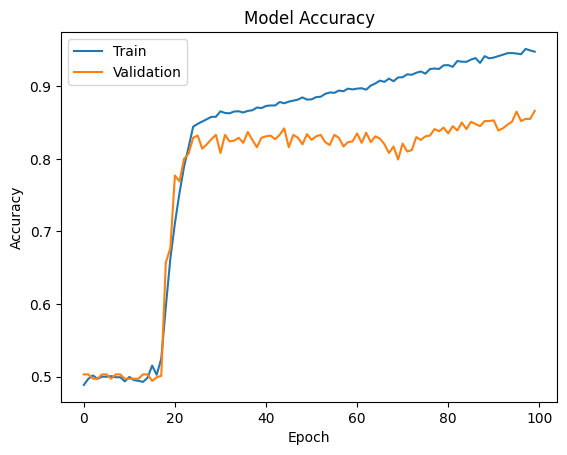

In [511]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Display the keys available in the training history
print(history.history.keys())

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Save the plot
plt.savefig('accuracy.png', dpi=180, facecolor='white')

# Display the plot
plt.show()

In [512]:
print(f"Accuracy achieved: {history.history['accuracy'][-1]*100:.2f}%")

Accuracy achieved: 94.76%


## Prediction/evaluation on given test set data

In [513]:
#model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 1s 4ms/step


In [514]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [515]:
# Display the story, question, and answer for the test_data[0]
text=''
print('Story:')

for sent in test_data[0]:
    if sent!='yes' and sent!='no':
        for word in sent:
            if (word!='.'):
                if (word!='?'):
                    text+= word + ' '
                else:
                    print()
                    print('Question:', text[:-1]+word)
                    print()
            else:
                print(text[:-1]+word)
                text=''
    else:
        print('True Answer:', sent,'\n')

Story:
Mary got the milk there.
John moved to the bedroom.

Question: Is John in the kitchen?

True Answer: no 



In [516]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9999981


# Prediction/evaluation on our own custom story and query
We can use only the words present in the vocabulary.

In [517]:
vocab, len(vocab)

({'.',
  '?',
  'Daniel',
  'Is',
  'John',
  'Mary',
  'Sandra',
  'apple',
  'back',
  'bathroom',
  'bedroom',
  'discarded',
  'down',
  'dropped',
  'football',
  'garden',
  'got',
  'grabbed',
  'hallway',
  'in',
  'journeyed',
  'kitchen',
  'left',
  'milk',
  'moved',
  'no',
  'office',
  'picked',
  'put',
  'the',
  'there',
  'to',
  'took',
  'travelled',
  'up',
  'went',
  'yes'},
 37)

In [518]:
def add_space_before_punctuation(input_string):
    punctuation = ['.', '?']
    output_string = ''

    for char in input_string:
        if char in punctuation:
            output_string += ' ' + char
        else:
            output_string += char

    return output_string

In [519]:
custom_story='Daniel went to kitchen . Sandra moved to office . Mary moved to bathroom'

In [520]:
custom_story=add_space_before_punctuation(custom_story)

In [521]:
custom_qn='Is Daniel in bathroom ?'

In [522]:
custom_data = [(custom_story.split(),custom_qn.split(),'no')]

In [523]:
custom_story,custom_qn,custom_data = vectorize_data(custom_data)

In [524]:
#model.load_weights(filename)
pred_results = model.predict(([custom_story, custom_qn]))

1/1 [==============================] - 0s 31ms/step


In [525]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9999989
